## TENSOR FLOW PARA PRINCIPIANTES (VI): Uso de la API Keras




En el Tutorial [II] mostró cómo implementar una red neuronal convolucional en TensorFlow. En dicho turorial escribimos algunas funciones auxiliares para crear las capas de la red y crear el modelo. Luego, en los tutoriales [III] y [IV] vimo lo importante de contar con una buena API de alto nivel que nos ayude de manera más simple crear nuestro grafo, ya que estás API hace que sea mucho más fácil implementar modelos complejos y reduce el riesgo de cometer errores en los códigos al crear los grafos.

Como hemos venido explicando, hay varias de estas API disponibles para TensorFlow: PrettyTensor (Tutorial [III]), Layers API  (tf.layers, ver Tutorial [IV]). En este tutorial trata sobre otra API, llamada Keras, que ya está muy desarrollada con muy buena documentación, y por las perspectivas, el desarrollo de ésta API continúa. Parece probable que Keras sea la API estándar para TensorFlow en el futuro.

El autor de Keras ha escrito una publicación (ver [blog]) sobre la filosofía dela API Keras , que recomendamos se debería leer.


Continuemos con el mismo ejemplo utilizado en los tutoriales enteriores ([II]-[V], pero ahora aplicando la API Keras Recordemos el esquema de la red neuronal convolucional que queremos implementar para la tarea del reconocimiento de dígitos escritos a mano:

![F1](imagenes/02_network_flowchart.png)

[II]:https://www.apsl.net/blog/2018/01/10/tensor-flow-para-principiantes-iii-uso-de-la-libreria-prettytensor/
[III]:https://www.apsl.net/blog/2018/01/10/tensor-flow-para-principiantes-iii-uso-de-la-libreria-prettytensor/
[IV]:https://www.apsl.net/blog/2018/01/19/tensor-flow-para-principiantes-iv-uso-de-la-api-layers/

[blog]:https://blog.keras.io/user-experience-design-for-apis.html

Importemos las librerías necesarias para implementra nuestra red:

Para instalar la API keras mirar la documentación en [https://keras.io/]

[https://keras.io/]:https://keras.io/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

## Import the keras API
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

/home/jcgonzalez/.virtualenvs/cv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extraemos los datos...

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

data.test.cls = np.argmax(data.test.labels, axis=1)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


Pasamos a definir el conjunto de variables para dar formato a las dimensiones de nuestras imágenes:

In [3]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
# This is used for plotting the images.
img_shape = (img_size, img_size)

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = (img_size, img_size, 1)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10



Función utilizada para trazar 9 imágenes en una cuadrícula de 3x3, y escribir las clases verdadera y predicha debajo de cada imagen.


In [4]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

miremos si todo va bien

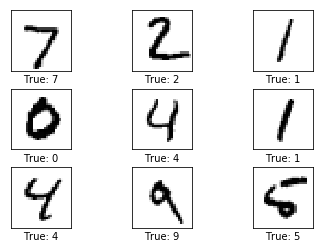

In [5]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

Función para trazar ejemplos de imágenes del conjunto de prueba que han sido clasificadas incorrectamente.

In [6]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != data.test.cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

Modelo secuencial

La API de Keras tiene dos modos de construir redes neuronales. El más simple es el modelo secuencial que solo permite que las capas se agreguen en secuencia. Más adelante vermeos la otra forma. A continuación en el código, explicaremos que hace cada línea.


In [7]:
# Comienza la construcción del modelo Keras Sequential.
model = Sequential()

# Agrega una capa de entrada que es similar a un feed_dict en TensorFlow.
# Tenga en cuenta que la forma de entrada debe ser una tupla que contenga el tamaño de la imagen.
model.add(InputLayer(input_shape=(img_size_flat,)))

# La entrada es una matriz aplanada con 784 elementos (img_size * img_size),
# pero las capas convolucionales esperan imágenes con forma (28, 28, 1), por tanto hacemos un reshape
model.add(Reshape(img_shape_full))

# Primera capa convolucional con ReLU-activation y max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                 activation='relu', name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Segunda capa convolucional con ReLU-activation y max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Aplanar la salida de 4 niveles de las capas convolucionales
# a 2-rank que se puede ingresar a una capa totalmente conectada 
model.add(Flatten())

# Primera capa completamente conectada  con ReLU-activation.
model.add(Dense(128, activation='relu'))

# Última capa totalmente conectada con activación de softmax
# para usar en la clasificación.
model.add(Dense(num_classes, activation='softmax'))

### Compilación modelo

La red neuronal ahora se ha definido y debe completarse agregando una función de coste, un optimizador y las métricas de rendimiento. Esto se llama modelo de "compilación" en Keras.

Podemos definir el optimizador y si queremos un mayor control de sus parámetros, entonces necesitamos crear una instancia de un objeto. Por ejemplo, podemos establecer la tasa de aprendizaje.

In [8]:
from tensorflow.python.keras.optimizers import Adam
optimizer = Adam(lr=1e-3)

Para un problema de clasificación como el de nuestro ejemplo (MNIST) que tiene 10 clases posibles, necesitamos usar la función de pérdida llamada categórica_crossentropy. La métrica de rendimiento que nos interesa es la precisión de la clasificación.

In [9]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Entrenamiento:

Ahora que el modelo se ha definido completamente, con su función de pérdida y su optimizador, podemos entrenarlo. Lo hacemos con la función **fit**. Esta función toma matrices numpy y realiza un número dado de épocas (epochs) de entrenamiento utilizando el tamaño de lote de datos dado. 

Una época es un uso completo de todo el conjunto de entrenamiento. Es decir, durante 10 epochs, iteramos aleatoriamente sobre todo el conjunto de entrenamiento 10 veces.

In [10]:
# entrenamos el modelo...
model.fit(x=data.train.images,
          y=data.train.labels,
          epochs=1, batch_size=128)

Epoch 1/1
55000/55000 [==============================] - 65s - loss: 0.2177 - acc: 0.9341    


Ahora que el modelo se ha entrenado, podemos probar su rendimiento en el conjunto de prueba. Esto también usa matrices numpy como entrada.


In [11]:
result = model.evaluate(x=data.test.images,
                        y=data.test.labels)

 9952/10000 [============================>.] - ETA: 0s

Imprimimos las métricas:

In [12]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.06030807785145007
acc 0.98


O podemos simplemente imprimir la precisión de la clasificación.

In [13]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

acc: 98.00%


Predicción

También podemos predecir la clasificación de nuevas imágenes. Simplemente usaremos algunas imágenes del conjunto de prueba, pero podría cargar sus propias imágenes en matrices numpy y usarlas en su lugar.


In [14]:
images = data.test.images[0:9]

La clase a la que pertenece

In [15]:
cls_true = data.test.cls[0:9]

Obtenemos las clases predichas como arreglos codificados One-Hot.

In [16]:
y_pred = model.predict(x=images)

Obtemos las clases predichas como enteros.

In [17]:
cls_pred = np.argmax(y_pred,axis=1)
print(cls_pred)
print(cls_true)

[7 2 1 0 4 1 4 9 5]
[7 2 1 0 4 1 4 9 5]


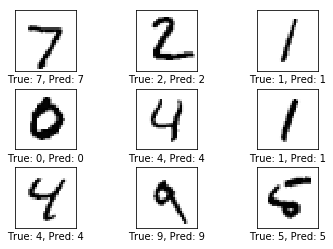

In [18]:
plot_images(images=images,
            cls_true=cls_true,
            cls_pred=cls_pred)

### Modelo funcional

Ahora vamos a suar la sugunda manera de crear redes con la API Keras. La API de Keras también se puede usar para construir redes más complicadas utilizando el Modelo funcional. Esto puede parecer un poco confuso al principio, porque cada llamada a la API de Keras creará y devolverá una instancia que se puede llamar. No está claro si se trata de una función o un objeto, pero podemos llamarlo como si fuera una función. Esto nos permite construir gráficos computacionales que son más complejos de lo que permite el Modelo Secuencial.

In [19]:
# Crea una capa de entrada que es similar a un feed_dict en TensorFlow.
# Tenga en cuenta que la forma de entrada debe ser una tupla que contenga el tamaño de la imagen.
inputs = Input(shape=(img_size_flat,))

# Variable utilizada para construir la red neuronal
net = inputs

# La entrada es una imagen como una matriz aplanada con 784 elementos.
# Pero las capas convolucionales esperan imágenes con forma (28, 28, 1)
net = Reshape(img_shape_full)(net)

# Primera capa convolucional con ReLU-activation y max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
             activation='relu', name='layer_conv1')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# Segunda capa convolucional con ReLU-activation y max-pooling
net = Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
             activation='relu', name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# Aplanar la salida de la capa conv de 4-dim a 2-dim.
net = Flatten()(net)

# Primera capa completamente conectada  con ReLU-activation.
net = Dense(128, activation='relu')(net)

# Última capa totalmente conectada  con activación de softmax
# por lo que se puede utilizar para la clasificación.
net = Dense(num_classes, activation='softmax')(net)

# Salida de la red neuronal
outputs = net

### Compilación modelo

Ahora hemos definido la arquitectura del modelo con su entrada y salida. Ahora tenemos que crear un modelo de Keras y compilarlo con una función de pérdida y un optimizador:

In [20]:
from tensorflow.python.keras.models import Model

Crea una nueva instancia del Modelo funcional Keras. Le damos las entradas y salidas de la Red Neural Convolucional que construimos anteriormente.

In [21]:
model2 = Model(inputs=inputs, outputs=outputs)

Compile el modelo Keras utilizando el optimizador rmsprop (ver [https://keras.io/optimizers/]) y con una función de pérdida para múltiples categorías. La única métrica de rendimiento que nos interesa es la precisión de la clasificación, pero puede usar una lista de métricas aquí.

[https://keras.io/optimizers/]:https://keras.io/optimizers/

In [22]:
model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

### Entrenamiento

El modelo ahora se ha definido y compilado para que pueda ser entrenado usando la misma función de ajuste **fit()** que se usa en el Modelo Secuencial anterior. Esto también toma matrices numpy como entrada.

In [29]:
model2.fit(x=data.train.images,
           y=data.train.labels,
           epochs=3, batch_size=128)

Epoch 1/1
55000/55000 [==============================] - 66s - loss: 0.0530 - acc: 0.9838    


### Evaluación

Una vez que el modelo ha sido entrenado, podemos evaluar su desempeño en el conjunto de prueba. Esta es la misma sintaxis que para el Modelo Secuencial.

In [30]:
result = model2.evaluate(x=data.test.images,
                         y=data.test.labels)

 9984/10000 [============================>.] - ETA: 0s

El resultado es una lista de valores, que contiene el valor de pérdida y todas las métricas que definimos cuando compilamos el modelo. Tenga en cuenta que la "precisión" ahora se llama "acc", que es una pequeña incoherencia.

In [31]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.03245465075906832
acc 0.9899


También podemos imprimir la precisión de clasificación como un porcentaje:

In [32]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

acc: 98.99%


### Guardar y Cargar Modelo

*NOTA: ¡Necesita instalar h5py para que esto funcione!*

El tutorial V trata sobre cómo guardar y restaurar los pesos de un modelo utilizando el código nativo TensorFlow.  Pudimos ver que podía ser algo engorroso ecsribir el código para ello.  Afortunadamente, Keras lo hace muy fácil.

Esta es la ruta de archivo en la que queremos guardar el modelo Keras.



In [27]:
path_model = 'model.keras'

Guardar un modelo Keras con los pesos entrenados es solo una llamada de función única, Esto lo hacemos con:

In [28]:
model2.save(path_model)

Ya hemos creado un archivo model.keras, con la estructura del grafo y los pesos de las variables y parámetros de la red.

Elimine el modelo de la memoria, de modo que estemos seguros de que ya no se usa.

In [33]:
del model2

Necesitamos importar esta función Keras para cargar el modelo.

In [34]:
from tensorflow.python.keras.models import load_model

para cargar el modelo usamos la sigueinte línea de código

In [35]:
model3 = load_model(path_model)

Ya tenemos la red neuronal cargada con sus pesos ya optimzados.
Podemos usar el modelo nuevamente, y  hacer predicciones.

In [37]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]

Usamos el modelo que hemos cargado (model3) para predecir los números de clase para esas imágenes.

In [38]:
y_pred = model3.predict(x=images)

Obtenga los números de clase como enteros.

In [42]:
cls_pred = np.argmax(y_pred, axis=1)

print(cls_pred)
print(cls_true)

[7 2 1 0 4 1 4 9 5]
[7 2 1 0 4 1 4 9 5]


Plot the images with their true and predicted class-numbers.

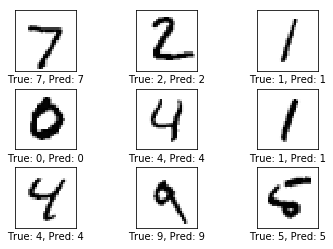

In [43]:
plot_images(images=images,
            cls_pred=cls_pred,
            cls_true=cls_true)

Podemos recuperar la estructura de la red de forma esquemática usando la siguiente línea de código con Keras:

In [44]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1764)              0         
__________

como vemos en el sumario, es la estructura del grafo de la figura esquemátatica del inicio de este artículo.
También podemos explorar cada una de las capas. Lo hacemos de la siguiente manera:

In [51]:
# La capa de entrada tiene el índice 0.
layer_input = model3.layers[0]
print(layer_input)


# La primera capa convolucional tiene el índice 1.
layer_conv1 = model3.layers[2]
print(layer_conv1)

# La segunda capa convolucional tiene el índice 1.
layer_conv2 = model3.layers[4]

### Pesos convolucionales

Ahora que tenemos las capas, podemos obtener sus pesos fácilmente.

Creamos una función auxiliar para trazar los pesos convolucionales:

In [52]:
def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

La capa de entrada tiene el índice 0.

In [56]:
weights_conv1 = layer_conv1.get_weights()[0]
print(weights_conv1.shape)

(5, 5, 1, 16)


Esto nos da un tensor de 4 rangos.

Dibujamos los pesos usando la función auxiliar que definimos anteriormente arriba.

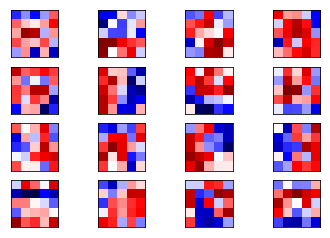

In [68]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

También podemos obtener los pesos para la segunda capa convolucional y trazarlos.

(5, 5, 16, 36)


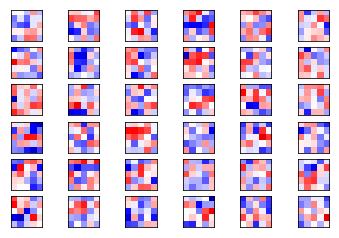

In [69]:
weights_conv2 = layer_conv2.get_weights()[0]
print(weights_conv2.shape)
plot_conv_weights(weights=weights_conv2, input_channel=0)

Función auxiliar para trazar la salida de una capa convolucional

In [70]:
def plot_conv_output(values):
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Imagen de entrada

Función auxiliar para trazar una sola imagen.

In [71]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

Trazamos una imagen del conjunto de prueba que se utilizará como ejemplo a continuación.

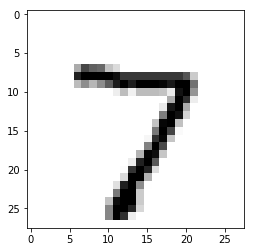

In [72]:
image1 = data.test.images[0]
plot_image(image1)

### Salida de la capa convolucional - Método 1

Hay diferentes formas de obtener la salida de una capa en un modelo Keras. Este método usa una llamada función K que convierte una parte del modelo Keras en una función.

In [75]:
from tensorflow.python.keras import backend as K

output_conv1 = K.function(inputs=[layer_input.input],
                          outputs=[layer_conv1.output])

Llamamos esta función con la imagen de entrada. Tenga en cuenta que la imagen está envuelta en dos listas porque la función espera una matriz de esa dimensionalidad. Del mismo modo, la función devuelve una matriz con una dimensionalidad más de la que queremos, así que simplemente tomamos el primer elemento.

In [77]:
layer_output1 = output_conv1([[image1]])[0]
print(layer_output1.shape)

(1, 28, 28, 16)


Ahora podemos trazar la salida de los 16 canales de la capa convolucional.

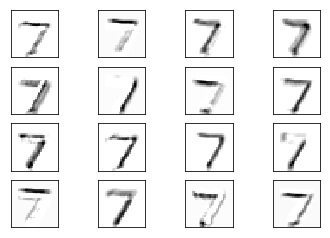

In [78]:
plot_conv_output(values=layer_output1)

### Salida de la capa convolucional - Método 2

Keras también tiene otro método para obtener la salida de una capa dentro del modelo. Esto crea otro modelo funcional que usa la misma entrada que el modelo original, pero el resultado ahora se toma de la capa convolucional en la que estamos interesados.

In [79]:
output_conv2 = Model(inputs=layer_input.input,
                     outputs=layer_conv2.output)

Esto crea un nuevo modelo-objeto donde podemos llamar a las funciones  típicas de Keras. Para obtener la salida de la capa convolutiva, llamamos a la función de predict() con la imagen de entrada.

In [80]:
layer_output2 = output_conv2.predict(np.array([image1]))
print(layer_output2.shape)

(1, 14, 14, 36)


Ahora podemos trazar la salida de los 36 canales de la capa convolucional.

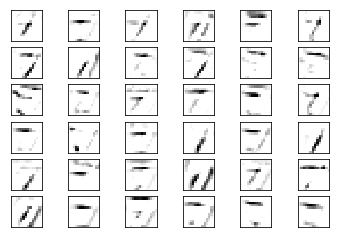

In [81]:
plot_conv_output(values=layer_output2)

### Conclusión

Este tutorial mostró cómo usar API Keras para construir fácilmente redes neuronales convolucionales en TensorFlow. Keras es, de lejos, la API más completa y mejor diseñada para TensorFlow.

Este tutorial también mostró cómo utilizar Keras para guardar y cargar un modelo, así como también obtener los pesos y resultados de capas convolucionales.

Parece probable que Keras sea la API estándar para TensorFlow en el futuro, por la sencilla razón de que ya es muy buena y se mejora constantemente. Por lo tanto, se recomienda que use Keras.